In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AICV

/content/drive/MyDrive/AICV


#  Object detection (faster_rcnn)

## 1. Import packages

In [ ]:
#!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 51.1 MB/s eta 0:00:00


In [ ]:
from __future__ import division

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

import os
import numpy as np

import xml.etree.ElementTree as ET

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
### Funtion for visualization
def draw_bb(img, boxes, color='r', figsize=(8,8)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes:
        rect = patches.Rectangle(
            (box[0],box[1]), # the upper left point
            box[2]-box[0],   # delta_x: width
            box[3]-box[1],   # delta_y: height
            linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g', figsize=(20,20)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes1:
        rect = patches.Rectangle(
            (box[0],box[1]),
            box[2]-box[0],
            box[3]-box[1],
            linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle(
            (box[0],box[1]),
            box[2]-box[0],
            box[3]-box[1],
            linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. Define Pascal VOC dataloader
> - annotations: JPEGImages의 정답 데이터 xml 파일(class명, 이미지 크기, bounding box 크기)
> - ImageSets: 특정 클래스가 어떤 이미지에 있는지 등에 대한 정보를 포함하는 폴더(test, trian, val, ...)
> - JPEGImages: jpg 확장자를 가진 이미지 파일
> - SegmentationClass: Semantic Segmentation을 학습하기 위한 label 이미지들
> - SegmentationObject: Instance Segmentation을 학습하기 위한 label 이미지들

- Pascal VOC dataset folder structure

data/VOC2007/  

>ImageSets/Main/  
>>train.txt  
>>train_small.txt(optional)  

>JPEGImages/  
>>000005.jpg  
>>000007.jpg  
>>000009.jpg  
>>000012.jpg  
>>...  

>Annotations/  
>>000005.xml  
>>000007.xml  
>>000009.xml  
>>000012.xml  
>>...  


### 2-1. Recap of the dataloader we define

In [ ]:
ttclasses = ('__background__',
             'aeroplane', 'bicycle', 'bird', 'boat',
             'bottle', 'bus', 'car', 'cat', 'chair',
             'cow', 'diningtable', 'dog', 'horse',
             'motorbike', 'person', 'pottedplant',
             'sheep', 'sofa', 'train', 'tvmonitor')
dict(zip(ttclasses, range(len(ttclasses))))

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [ ]:
ttfilename = os.path.join('./VOC2007/', 'Annotations', '000001' + '.xml')
ET.parse(ttfilename).find('object').find('name').text.lower().strip()

'dog'

In [ ]:
class PascalDataset(Dataset):
    def __init__(self, voc_root, image_set, transforms=None):
        ### Data root, transform
        self.data_root = voc_root
        self.transforms = transforms

        ### class name to class label mapping
        self._classes = ('__background__',
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self._class_to_ind = dict(zip(self._classes, range(len(self._classes)))) # zip(list1, list2): list1과 list2를 짝지어서 반환 / dict(key, value) key값 들어오면 value 반환


        ### Load image list
        self.img_list = []
        splits_dir = os.path.join(voc_root, 'ImageSets/Main') ## splits_dir = 'voc_root/ImageSets/Main'
        split_f = os.path.join(splits_dir, image_set + '.txt')## split_f = voc_root/ImageSets/Main/train.txt(or trainval.txt or val.txt)
        self._load_img_name_list(split_f)

    def _load_img_name_list(self, img_list_path):
        with open(img_list_path) as f:
            self.img_list = f.read().splitlines() # 문자열 한 줄씩 읽기

    def _load_annotation(self, index, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml') ## file_name = 'self.data_root/Annotations/image_path.xml'
        tree = ET.parse(filename) # 전체 XML 문서를 트리로 나타냄
        objs = tree.findall('object') # XML 문서 중 tag가 object인 애들을 모두 찾기
        num_objs = len(objs)

        boxes = np.zeros((num_objs, 4), dtype=np.float32)
        gt_classes = np.zeros((num_objs, ), dtype=np.int64)

        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox') # bndbox tag인 곳을 찾기

            # Make pixel indexes 0-based (기존은 1에서부터 시작)
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1

            cls = self._class_to_ind[obj.find('name').text.lower().strip()] # obj의 name을 key값으로 넣고, class의 index 찾기/소문자/앞뒤 공백 제거
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls

        target = {}
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        target["boxes"] = boxes ## Bounding Box Annotation을 텐서로 만듦
        target["labels"] = torch.as_tensor(gt_classes, dtype=torch.int64) ## Class Label을 텐서로 만듦
        target["image_id"] = torch.tensor([index]) ## 이미지 아이디
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) ## (ymax-ymin)*(xmax-xmin) = w*h
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        return target

    def __len__(self):## Essential Function in Custom Dataset
        return len(self.img_list)

    def __getitem__(self, index):## Essential Function in Custom Datset
        ### Load images
        img_path = self.img_list[index]
        img = Image.open(os.path.join(self.data_root,'JPEGImages',img_path + '.jpg')).convert("RGB")

        ### Load label dictionary
        target = self._load_annotation(index, img_path)

        ### Transform
        if self.transforms is not None:
            img, target = self.transforms(img), target
        return img, target

In [ ]:
class PascalDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, voc_root, collate_fn, transforms = None):
        super().__init__()

        self.batch_size = batch_size
        self.voc_root = voc_root
        self.transfoms = transforms
        self.collate_fn = collate_fn


    def setup(self, stage=None):
        if stage == 'fit' or stage == None:
            self.voc_train = PascalDataset(self.voc_root, image_set='train', transforms=self.transfoms)

        if stage == 'test' or stage == None:
            self.voc_test = PascalDataset(self.voc_root, image_set='val', transforms=self.transfoms)

    def train_dataloader(self):
        return DataLoader(self.voc_train, batch_size=self.batch_size, shuffle=True, num_workers=4, collate_fn=self.collate_fn)
        # num_workers:  how many subprocesses to use for data loading
        # collate_fn: merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style dataset.

    def test_dataloader(self):
        return DataLoader(self.voc_test, batch_size=self.batch_size, shuffle=False, num_workers=4, collate_fn=self.collate_fn)

In [ ]:
# transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalization value
])

# collate_fn 정의
# collate_fn: Loss를 계산하고 학습하려면 label을 output tensor와 동일한 형태로 구성을 해야하기 때문에 사용하는 파라미터
def collate_fn(batch):
    zip_batch = zip(*batch)
    tuple_batch = tuple(zip_batch)
    return tuple_batch

In [ ]:
res = [['a', 'b', 'c'], [1, 2, 3]]
tuple(zip(*res))

(('a', 1), ('b', 2), ('c', 3))

In [ ]:
# datamodule 불러오기
voc_dm = PascalDataModule(batch_size=16, voc_root='./VOC2007/', collate_fn = collate_fn, transforms = transform)
voc_dm.setup()

# train, test에 있는 data 개수 확인
print('[# of data]')
print('  Train\t:', len(voc_dm.voc_train))
print('  Test\t:', len(voc_dm.voc_test))

# train, test batch 개수 확인
print('\n[# of batch]')
print('  Train\t:', len(voc_dm.train_dataloader()))
print('  Test\t:', len(voc_dm.test_dataloader()))

[# of data]
  Train	: 2501
  Test	: 2510

[# of batch]
  Train	: 157
  Test	: 157


### 2-2. Visualize a sample

torch.Size([3, 333, 500]) 
 {'boxes': tensor([[155.,  96., 350., 269.]]), 'labels': tensor([7]), 'image_id': tensor([0]), 'area': tensor([33735.]), 'iscrowd': tensor([0])}


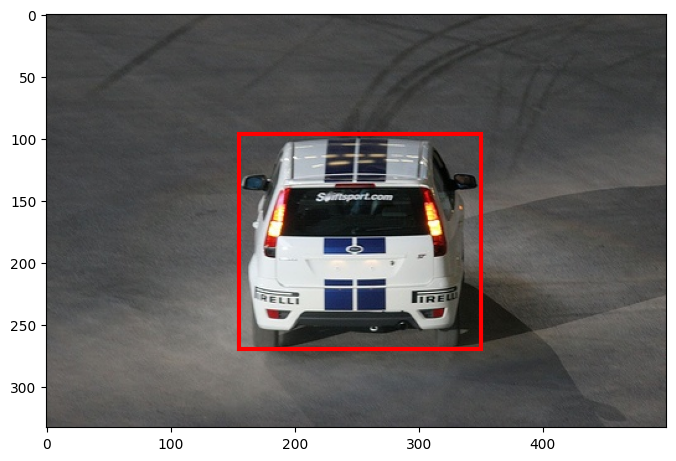

In [ ]:
transfroms = transforms.Compose([
    transforms.ToTensor()
])

voc_data = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_iter = iter(voc_data)
img, label = next(voc_iter)

print(img.shape, '\n', label)

img_PIL = transforms.ToPILImage()(img.clone())
bb_label = label['boxes']
draw_bb(img=img_PIL, boxes=bb_label)

## 3. Define Faster-RCNN

https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn.html

In [ ]:
class Faster_RCNN(pl.LightningModule):
    def __init__(self, pretrained, num_classes):
        super().__init__()

        self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=pretrained)

        self.num_classes = num_classes
        self.in_features = self.model.roi_heads.box_predictor.cls_score.in_features

        self.model.roi_heads.box_predictor = FastRCNNPredictor(self.in_features, self.num_classes)

    def forward(self, images):
        out = self.model(images)
        return out

    def training_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # separate losses
        loss_dict = self.model(images, targets)
        # total loss
        losses = sum(loss for loss in loss_dict.values())
        self.log('train_loss', losses , on_step=True, on_epoch=True, logger=True)
        # https://pytorch-lightning.readthedocs.io/en/stable/extensions/logging.html

        # on_step:  Logs the metric at the current step
        # on_epoch: Automatically accumulates and logs at the end of the epoch.
        # logger: Logs to the logger like Tensorboard, or any other custom logger passed to the Trainer

        return losses

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)

In [ ]:
#torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=True).roi_heads

## 4. Fine-tune Faster-RCNN.

In [ ]:
model = Faster_RCNN(pretrained=True, num_classes=21)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_320_fpn-907ea3f9.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 196MB/s]


In [ ]:
trainer = pl.Trainer(accelerator="gpu",
                     devices="auto",
                     max_epochs=5)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# GPU 필요, 시간 소요
trainer.fit(model, train_dataloaders=voc_dm.train_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 19.0 M | train
---------------------------------------------
19.0 M    Trainable params
58.9 K    Non-trainable params
19.0 M    Total params
76.110    Total estimated model params size (MB)
280       Modules in train mode
0         Modules in eval mode
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
# 학습한 파라미터 저장
torch.save(model.state_dict(), './detection_model_checkpoint.pth')

In [ ]:
# 불러와서 사용
model_path = './detection_model_checkpoint.pth'
model.load_state_dict(torch.load(model_path))

<ipython-input-21-a052027a0d8b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
# predefined evaluation function
# !pip install pycocotools
from engine import evaluate

# 모델을 GPU에 올림
if torch.cuda.is_available():
    model.cuda()

# https://cocodataset.org/#detection-eval
# colab A100 기준, 10 compute units 사용 후 expired. > 불가
# 하단에 결과 첨부
evaluate(model, voc_dm.test_dataloader(), device=device)

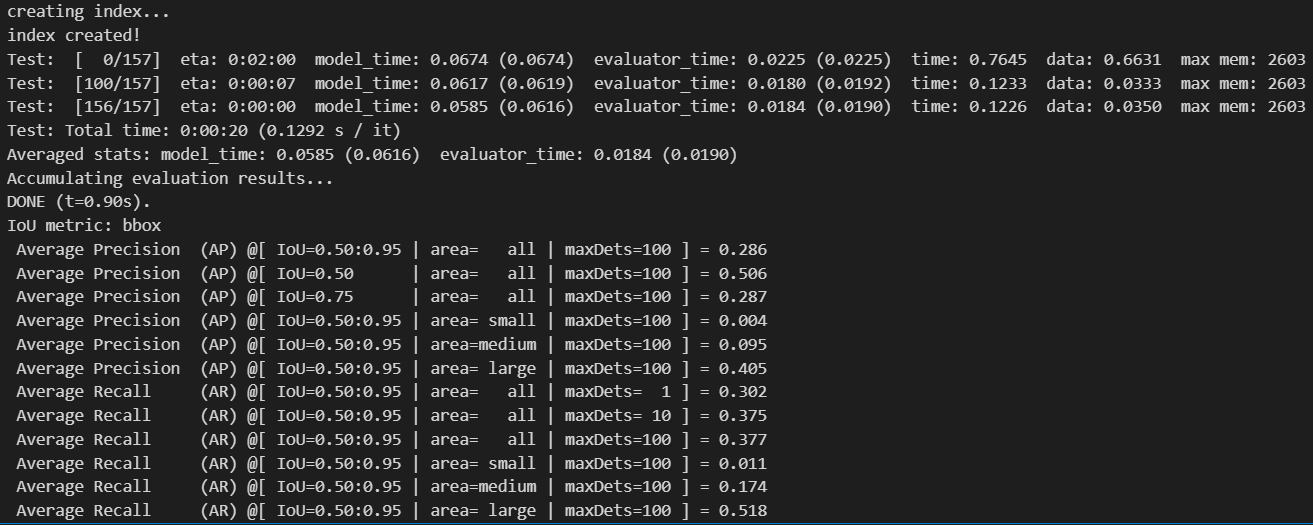

- precision: TP/(TP+FP) => Postive로 예측한 것들 중에 실제 Positive인 것들의 비율  
- recall: TP/(TP+FN) => 실제 Positive 중에 positive 제대로 예측한 비율  
- AP: PR 곡선에서 그래프 선 아래 쪽 면적. 높을수록 성능이 좋음을 뜻함.  
- AR: 특정 임계값 구간(여기서는 [0.5,0.95])에 해당하는 IoU들의 recall값을 y축에, 임계값 구간을 x 축에 두고 그래프 아래쪽 면적. 높을수록 좋은 성능
- area: 물체 크기에 (32^2보다 작으면 samll, 96^2보다 크면 large, 중간이면 medium)
- maxDets: n detection per image

## 5. Visulize the evaluation results.

In [ ]:
# eval mode
model.cpu()
model.eval();

In [ ]:
data_it = iter(voc_dm.test_dataloader())

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.9065, 0.5537, 0.4505, 0.1596, 0.1161, 0.1077, 0.0814, 0.0637, 0.0603,
        0.0536], grad_fn=<IndexBackward0>)
1


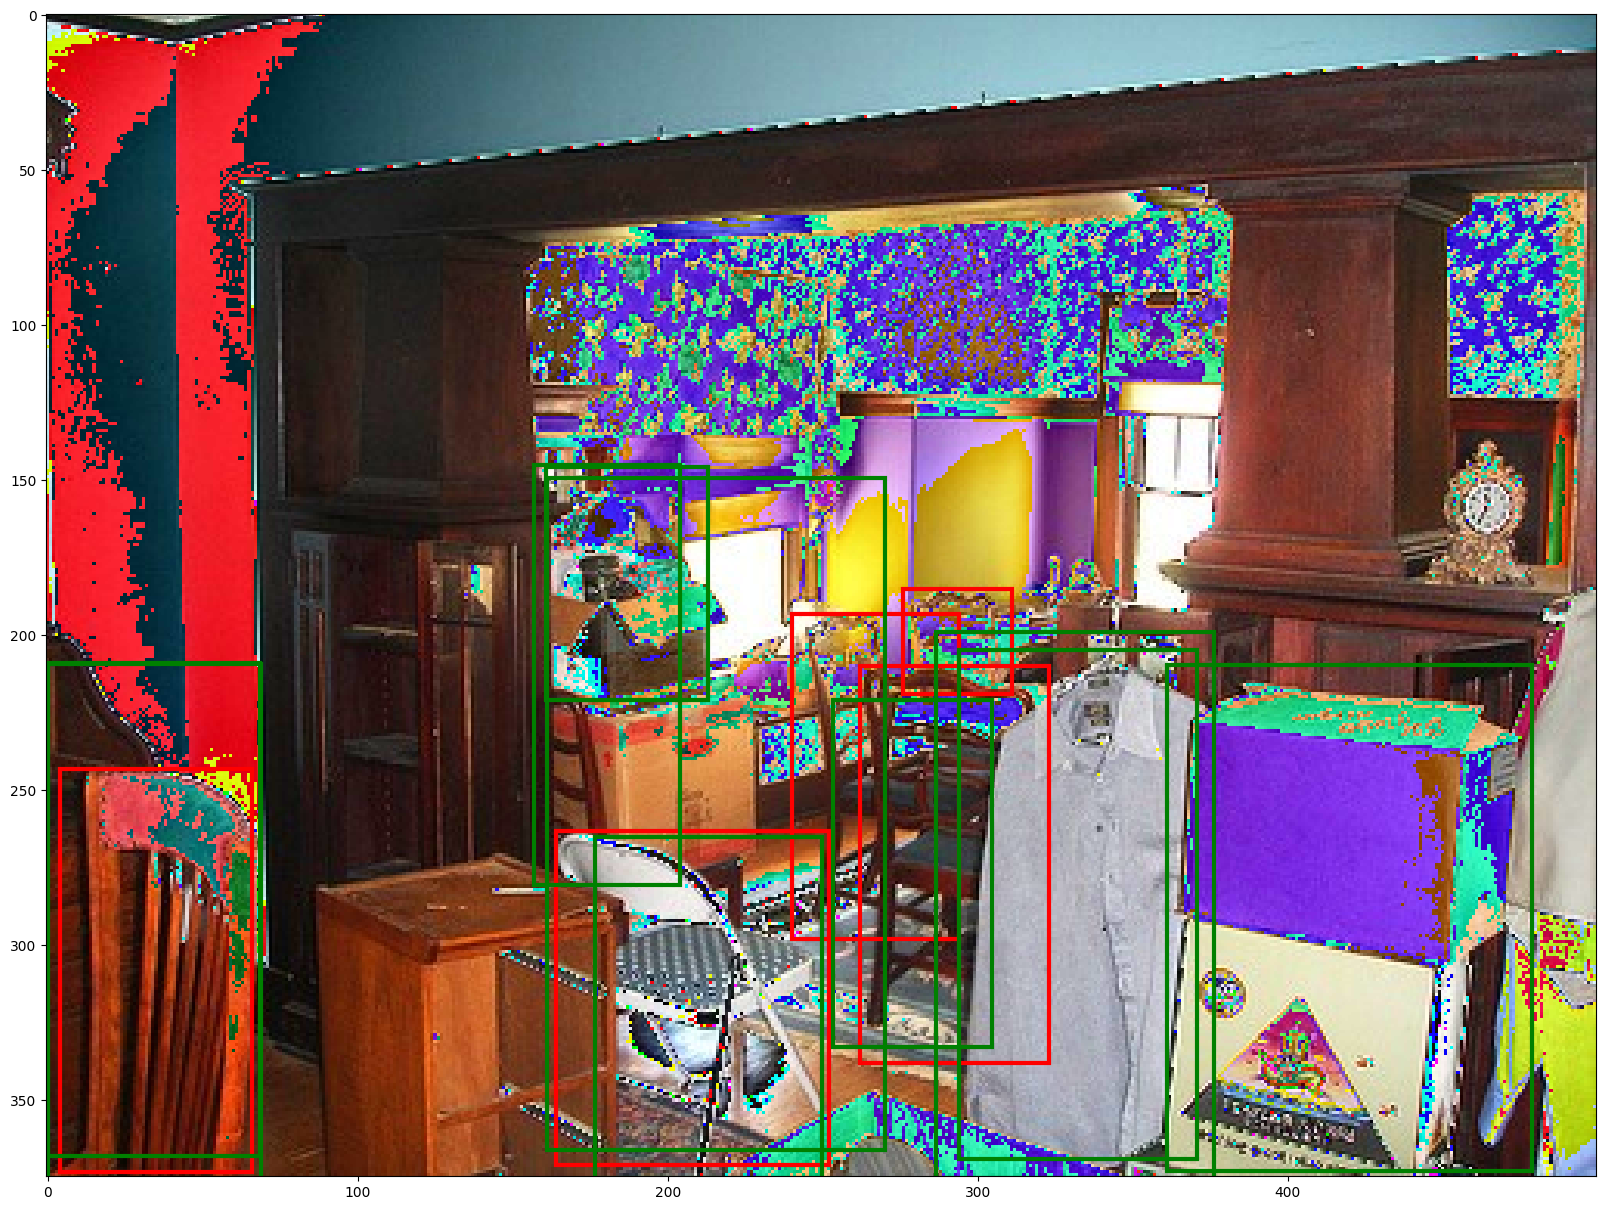

tensor([ 9, 15,  9, 20, 15, 20,  9, 15, 18,  9])
[[  0.      209.3219   68.84081 375.     ]
 [156.80583 145.17181 204.01772 280.6234 ]
 [176.6181  264.9936  249.77815 375.     ]
 [293.93576 204.81905 370.66287 368.99728]
 [161.16057 149.31766 270.18143 366.12146]
 [361.22433 209.70535 478.7519  372.9299 ]
 [253.18936 220.85509 304.55096 332.78635]
 [160.80766 145.77304 212.95486 220.75136]
 [  0.      209.07858  68.36428 367.99597]
 [286.61627 199.04698 376.1209  375.     ]]


In [ ]:
imgs, labels = next(data_it)

img_test = imgs[0]
bbox_test = labels[0]['boxes']

prediction = model(list([img_test]))

scores = prediction[0]['scores']
print(scores)

threshold = (scores>0.8).sum().cpu().detach().item()
print(threshold)

### transform for visulization
P = torchvision.transforms.ToPILImage()
img_test_PIL = P(img_test)
prediction_bbox_np = prediction[0]['boxes'].cpu().detach().numpy()#[:threshold]
draw_bb2(img_test_PIL, bbox_test, prediction_bbox_np) # red box: original box, green box: predicted box

print(prediction[0]['labels'])
print(prediction_bbox_np)

## (Optional) Test on an image you want.

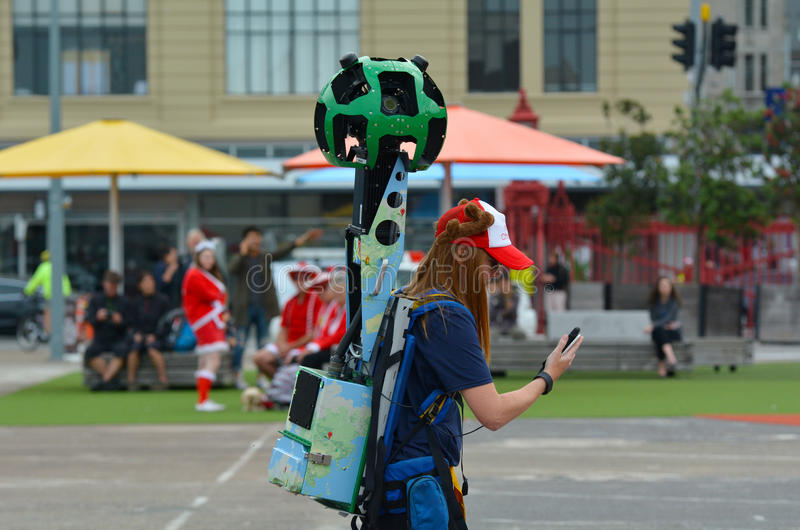

In [ ]:
# read image
img_demo = Image.open('./sample.jpg').convert("RGB")
img_demo

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.7985, 0.6268, 0.6014, 0.4552, 0.4442, 0.3793, 0.2579, 0.2507, 0.1181,
        0.1005, 0.0967, 0.0888])
tensor([0.7985, 0.6268, 0.6014, 0.4552, 0.4442, 0.3793, 0.2579, 0.2507, 0.1181,
        0.1005])
tensor([15, 15, 15, 15, 15, 15, 15, 15,  7, 15])
tensor([[649.2792, 284.1224, 688.1794, 378.2072],
        [718.7814, 277.8856, 760.7447, 368.9770],
        [283.3113, 116.4817, 568.2155, 524.4877],
        [355.4699, 251.6035, 573.0820, 519.1904],
        [175.9400, 228.8808, 239.0542, 397.2579],
        [238.1492, 228.5058, 295.1829, 396.8205],
        [ 82.3719, 257.8651, 136.8771, 371.2251],
        [646.9107, 285.3899, 666.3850, 372.1396],
        [  2.5592, 274.4932,  60.8828, 351.6934],
        [ 23.3937, 260.8832,  70.5776, 353.4426]])


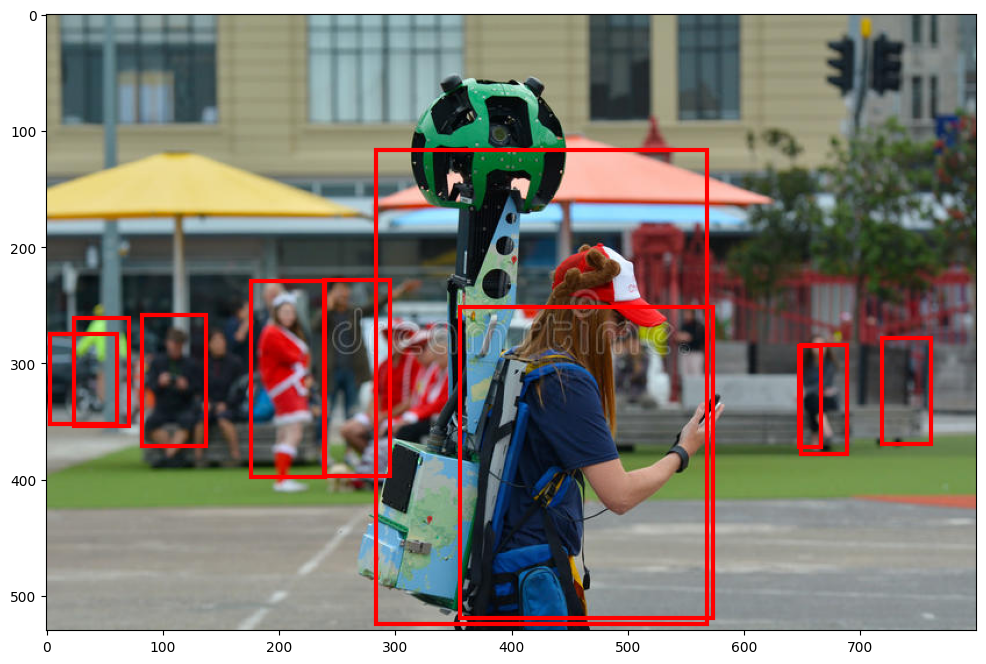

In [ ]:
# Forward through trained model
model.eval();

bboxes_demo = model([torchvision.transforms.ToTensor()(img_demo)])[0]['boxes'].cpu().detach()
scores_demo = model([torchvision.transforms.ToTensor()(img_demo)])[0]['scores'].cpu().detach()
labels_demo = model([torchvision.transforms.ToTensor()(img_demo)])[0]['labels'].cpu().detach()

threshold = (scores_demo>0.1).sum().item()

print(scores_demo)
print(scores_demo[:threshold])
print(labels_demo[:threshold])
print(bboxes_demo[:threshold])

# Draw bounding boxes
draw_bb(img_demo, bboxes_demo[:threshold], 'r', (12, 12))

In [ ]:
# nms 실습에서 하셨던 것과 동일
def nms(boxes, scores, threshold):
    """
    boxes: (N, 4), each row-> (x1, y1, x2, y2), x2 > x1, y2 > y1
    scores: (N,), each value in [0, 1]
    threshold: iou threshold
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()

    keep = []

    while len(order) > 0:
        # the index with the highest score.
        idx = order[-1]
        # keep it.
        keep.append(boxes[idx])
        # remove the index from the candidate list.
        order = order[:-1]

        if len(order) == 0:
            break # check

        # order bounding boxes according to the order.
        xx1 = x1[order]
        xx2 = x2[order]
        yy1 = y1[order]
        yy2 = y2[order]

        # intersection coordinate
        ix1 = torch.max(xx1, boxes[idx, 0])
        iy1 = torch.max(yy1, boxes[idx, 1])
        ix2 = torch.min(xx2, boxes[idx, 2])
        iy2 = torch.min(yy2, boxes[idx, 3])

        # width and height of the intesection, calculate intersection
        w = torch.clamp(ix2-ix1, min=0.)
        h = torch.clamp(iy2-iy1, min=0.)

        inter = w*h
        rem_areas = areas[order] + areas[idx] - 2*inter
        union = rem_areas + inter
        iou = inter / union

        # keep the boxes with iou less than threshold
        order = order[iou<threshold]

    return keep

7


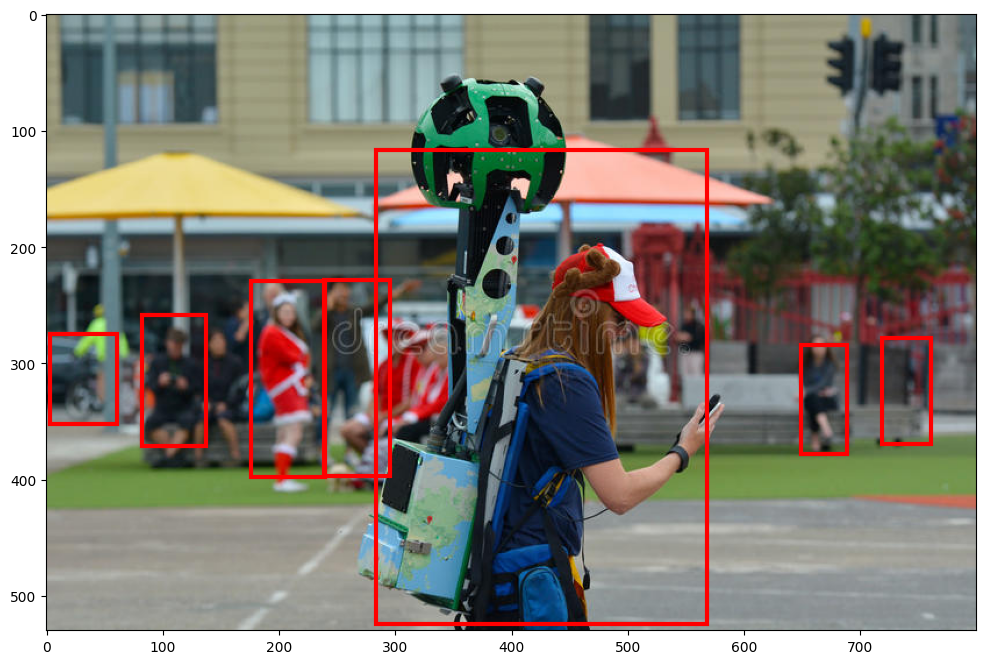

tensor([0.7985, 0.6268, 0.6014, 0.4552, 0.4442, 0.3793, 0.2579])
person
person
person
person
person
person
person


In [ ]:
classes = ('__background__',
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
indexes_to_classes = dict(zip(range(len(classes)), classes))
nms_boxes = nms(bboxes_demo[:threshold], scores_demo[:threshold], 0.3)
print(len(nms_boxes))
draw_bb(img_demo, nms_boxes, 'r', (12, 12))
print(scores_demo[:len(nms_boxes)])
for i in labels_demo[:len(nms_boxes)]:
    print(indexes_to_classes[i.item()])